In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline

In [3]:
# =============================================================================
# Constants and conversion factors : 
# =============================================================================

users = 351     # number of apartment units
cms_per_gpm = 6.309e-5
ns_per_s = 1e9
kg_per_lb = 0.453
s_per_interval = 30
s_per_hr = 3600
kwh_per_mwh = 1000
j_per_kj = 1000
ccf_to_therms = 1.037
emission_per_therm = 5.3 #(kg)
no_of_boilers = 3

In [4]:
# =============================================================================
# Water heater model definition : 
# =============================================================================

c_p = 4184                    # Units: J / kg / K
V = 0.3195                  # Units: m^3
rho = 1000                    # Units: kg / m^3
R = 4.11                       # Units: K / W  (divided by cross sectional area : 9/0.01)
T_out = 60 + 273.15           # Units: K
T_in = 20 + 273.15            # Units: K
T_o = 25 + 273.15
T_set = 60 + 273.15
K = 2 * 1e5
H_in = 1

def waterheater(t, T, H_in, Q, T_in):
    H_in = - K * (T - T_set)
    result = (H_in + (c_p * rho * Q(t) * T_in(t)) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
    return result 

def sol_func(time_start, time_end, Q, T_in):
    sol = scipy.integrate.solve_ivp(waterheater, [time_start, time_end],
                                    [T_out], args=(H_in, Q, T_in),
                                    method='LSODA', dense_output=True, max_step=600)
    return sol

In [5]:
# =============================================================================
# Import and read file:
# =============================================================================

SitesData = pd.read_csv("../data/site_a.csv")
Watttime = pd.read_csv("../data/ERCOT_EASTTX-MOER_2021-2023.csv", index_col=0)

# Convert timestamp strings to datetimes
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
Watttime['timestamp_local'] = pd.to_datetime(Watttime['timestamp_local'])
Watttime['timestamp_utc'] = pd.to_datetime(Watttime['timestamp_utc'])

In [6]:
# =============================================================================
# Test for duplicate time indices:
# =============================================================================

assert not SitesData.duplicated(subset=['TimeStamp']).any()
assert not Watttime.duplicated(subset=['timestamp_utc']).any()

In [7]:
# =============================================================================
# Set time index
# =============================================================================

# Set indices to time index
SitesData.set_index('TimeStamp', inplace=True)
Watttime.set_index('timestamp_utc', inplace=True)

# Sort time index
SitesData.sort_index(inplace=True)
Watttime.sort_index(inplace=True)

########### CHANGED
# Time zone
SitesData = SitesData.tz_localize('UTC')

# Resample site data to 30s intervals
SitesData = SitesData.resample('30s').mean()

In [8]:
# =============================================================================
# Read Flow and time stamp columns:
# =============================================================================

flow_gpm = SitesData['FT1_GPM']

In [9]:
# =============================================================================
# Replacing erroneous negative flow values with zero:
# =============================================================================

flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(0., inplace=True)
flow_gpm[flow_gpm < 0] = 0.

In [10]:
# =============================================================================
# convert flow units and smooth:
# =============================================================================
flow_cms = flow_gpm * cms_per_gpm
flow_per_user_cms = flow_cms / users
flow_per_user_cms_rolling_mean = flow_per_user_cms.rolling(120, min_periods=1, center=True).mean()
flow_time_s = flow_per_user_cms_rolling_mean.index.astype(int).values / ns_per_s
flow_values_cms = flow_per_user_cms_rolling_mean.values

In [11]:
cwt_fahrenheit = SitesData['CWT']
cwt_celsius = 5 / 9 * (SitesData['CWT'] - 32)
cwt_time_s = cwt_celsius.index.astype(int).values / ns_per_s
cwt_celsius = cwt_celsius.resample('1d').median().reindex(SitesData.index).interpolate().fillna(cwt_celsius.median())
cwt_kelvin = cwt_celsius + 273.15

In [12]:
# =============================================================================
# Create function to interpolate flow:
# =============================================================================

time_start = flow_time_s.min()
time_end = flow_time_s.max()
Q = interp1d(flow_time_s,
             flow_values_cms,
             kind='cubic', fill_value=flow_values_cms.mean())          # interp1d is the interpolation function used and Q contains ..
                                                   # ..interpolated flow values that are used as input into the solver 'sol'
Tc = interp1d(cwt_time_s,
              cwt_kelvin,
              kind='cubic', fill_value=20.)

In [13]:
# =============================================================================
# Evaluate heat balance in boiler over time given measured flow data
# =============================================================================

sol = sol_func(time_start, time_end, Q, Tc)          # Implementing the sol function to integrate the dT/dt where T.. 
                                                 #..is the temperature of the water in the water tank.


In [14]:
# y contains the interpolated flow values : 
y = pd.Series(np.where(flow_is_nan, np.nan, Q(flow_time_s)),
              index=flow_per_user_cms_rolling_mean.index)      # UNITS :m3/s along the y axis)


In [15]:
# y1 contains the difference between temperature in the tank and the set-point temperature 
y1 = pd.Series(np.where(flow_is_nan, np.nan, sol.sol(flow_time_s).ravel()), 
               index=flow_per_user_cms_rolling_mean.index)    


In [16]:
# y2 is the heat input in kilowatts
y2 = pd.Series(np.where(flow_is_nan, np.nan, -K*(sol.sol(flow_time_s).ravel() - T_set) / j_per_kj), 
               index=flow_per_user_cms_rolling_mean.index)

In [17]:
# =============================================================================
# Find heat energy input at 5 minute intervals that match with WattTime data
# =============================================================================

h_in_kw = pd.Series(-K * (sol.sol(flow_time_s).ravel() - T_set) / j_per_kj,
                    index=flow_per_user_cms_rolling_mean.index)
h_in_kw = h_in_kw.where(~flow_is_nan)
h_in_kj = s_per_interval * h_in_kw
h_in_kwh_5m = h_in_kj.resample('5min').sum() / s_per_hr

In [18]:
######### TEMPORARY

#Watttime_reflect = pd.concat([Watttime.loc['20210101':].copy(), 
#                             Watttime.loc['20210101':].copy()
#                             .set_index(Watttime.loc['20210101':].index + pd.Timedelta('1y')),
#                             Watttime.loc['20210101':].copy()
#                             .set_index(Watttime.loc['20210101':].index + pd.Timedelta('2y'))])

In [19]:
#Watttime_reflect = Watttime_reflect.resample('5min').mean().interpolate()

In [20]:
Watttime = Watttime.resample('5min').mean().interpolate()

In [21]:
# =============================================================================
# Import and arrange emissions data for the required period
# =============================================================================

# Get Watttime data corresponding to SitesData time period
####### TEMPORARY
Watttime = Watttime[(Watttime.index >= h_in_kwh_5m.index.min()) 
                    & ((Watttime.index <= h_in_kwh_5m.index.max()))]
#Watttime_reflect = Watttime_reflect[(Watttime_reflect.index >= h_in_kwh_5m.index.min()) 
#                    & ((Watttime_reflect.index <= h_in_kwh_5m.index.max()))]

# Note that this is in pounds
####### TEMPORARY
emissions_lbs_per_MWh = Watttime['value']
emissions_kg_per_kWh = emissions_lbs_per_MWh * kg_per_lb / kwh_per_mwh
kwh_and_emissions = (pd.concat([h_in_kwh_5m, emissions_kg_per_kWh], axis=1).dropna()
                     .rename(columns={0 : 'kwh', 'value' : 'kg / kwh'}))
daily_emissions_kg = (kwh_and_emissions['kwh'] * kwh_and_emissions['kg / kwh']).resample('d').sum()
# =============================================================================
# Average daily emissions (kg CO2 / day):
# =============================================================================
daily_emissions_kg.where(daily_emissions_kg > 0).mean()


1.4955539681666679

In [22]:
emissions_kg_per_kWh.where(daily_emissions_kg > 0).mean() * h_in_kwh_5m.where(h_in_kwh_5m > 0).resample('1d').sum().mean()

1.3730029131547048

In [23]:
daily_emissions_kg.where(daily_emissions_kg > 0).mean() / (emissions_kg_per_kWh.where(daily_emissions_kg > 0).mean() * h_in_kwh_5m.where(h_in_kwh_5m > 0).resample('1d').sum().mean())

1.0892576802553036

In [24]:
ERWH_daily_emissions = daily_emissions_kg.where(daily_emissions_kg >= 0)

In [25]:
hpwh_emissions = pd.read_csv('../data/emissions_site_a_hpwh_daily.csv')
hpwh_emissions.rename(columns={'Unnamed: 0' : 'timestamp_utc'}, inplace=True)
hpwh_emissions['timestamp_utc'] = pd.to_datetime(hpwh_emissions['timestamp_utc'])
hpwh_emissions.set_index('timestamp_utc',inplace = True)

In [26]:
#### TEMPORARY
hpwh_emissions[ERWH_daily_emissions == 0] = np.nan

In [27]:
hpwh_emissions['0'].where(hpwh_emissions['0'] > 0).mean()

0.34852029662679984

In [28]:
import seaborn as sns
import matplotlib.dates as mdates

In [29]:
standby = 0.75
therm_per_j = 9.48043e-9

ng_model = ((1 / standby) * (c_p * (T_set - cwt_kelvin) 
                          * (flow_cms.replace(0., np.nan) * s_per_interval) 
                          * rho * therm_per_j) 
            * emission_per_therm / users).resample('1d').sum().replace(0., np.nan)

In [30]:
ng_model.mean()

0.7074454264665779

In [31]:
droplist = ['2021-05-18', '2021-06-23', '2021-09-21', '2021-09-30', '2021-09-30', '2021-10-26',
            '2022-03-12', '2022-03-13', '2022-03-14', '2022-03-15', '2022-03-16',
            '2022-03-23', '2022-04-04', '2022-04-05', '2022-10-21', '2022-10-22', 
            '2022-10-23', '2022-10-24', '2022-10-25']

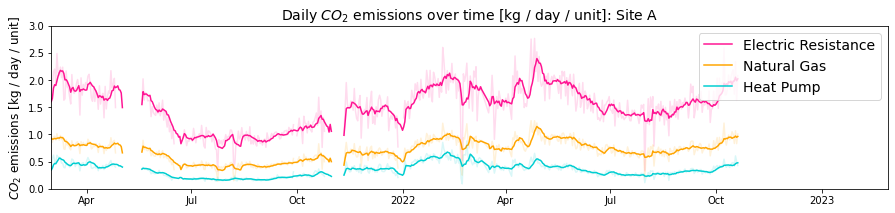

In [32]:
# =============================================================================
# Plotting: Emissions (ERWH vs natural gas vs HPWH)
# =============================================================================
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(ERWH_daily_emissions.replace(0, np.nan).drop(droplist).rolling('1d').mean(), c='deeppink', alpha=0.15)
ax.plot(ERWH_daily_emissions.replace(0, np.nan).drop(droplist).rolling('7d').mean(), c='deeppink', label='Electric Resistance')
plt.plot(ng_model.drop(droplist).rolling('1d').mean(), c='orange', alpha=0.15)
plt.plot(ng_model.drop(droplist).rolling('7d').mean(), c='orange', label='Natural Gas')
ax.plot(hpwh_emissions['0'].drop(droplist), c='darkturquoise', alpha=0.15)
ax.plot(hpwh_emissions['0'].drop(droplist).rolling('7d').mean(), c='darkturquoise', label='Heat Pump')
ax.set_title('Daily $CO_2$ emissions over time [kg / day / unit]: Site A', size=14)
ax.set_ylabel('$CO_2$ emissions [kg / day / unit]', size=12)
plt.legend(fontsize=14)
ax.set_xlim(pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-28'))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylim(0, 3)
fig.savefig('../img/site_a_emissionsplot_daily.png',dpi=200, bbox_inches='tight')

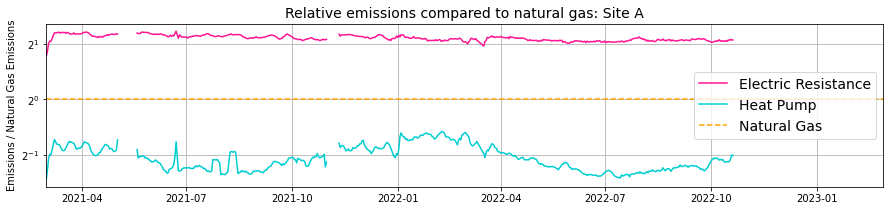

In [33]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.semilogy(ERWH_daily_emissions.replace(0, np.nan).drop(droplist).rolling('7d').mean()
         / ng_model.drop(droplist).rolling('7d').mean(), c='deeppink', label='Electric Resistance', base=2)
plt.semilogy(hpwh_emissions['0'].drop(droplist).rolling('7d').mean() 
         / ng_model.drop(droplist).rolling('7d').mean(), c='darkturquoise', label='Heat Pump', base=2)
plt.axhline(1, linestyle='--', c='orange', label='Natural Gas')
ax.set_xlim(pd.Timestamp('2021-03-01'), pd.Timestamp('2023-02-28'))
ax.grid(which='both', zorder=-5)
plt.title('Relative emissions compared to natural gas: Site A', size=14)
plt.legend(fontsize=14)
plt.ylabel('Emissions / Natural Gas Emissions')
fig.savefig('../img/site_a_relative_emissions.png',dpi=200, bbox_inches='tight')

In [34]:
output = pd.concat([ERWH_daily_emissions, hpwh_emissions['0'], ng_model], axis=1)
output.columns = ['ERWH', 'HPWH', 'NGWH']
output.to_csv('../data/site_a_emissions_results.csv')